In [1]:
from __future__ import division
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
from collections import Counter
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster
import datetime as dt
import numpy as np
import scipy.stats as stats
from numpy import transpose as T
import sys
sys.stdout.write('.')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

CONDIR = os.environ.get("CONDIR")

.

# Preparation

### Read in data

In [2]:
gsr = '' if True else '_gsr'
connectomes = np.load(os.path.join(CONDIR,'derivatives/connectomes%s.npy'%gsr))
results = pd.read_csv(os.path.join(CONDIR,'derivatives/connectome_results.csv'))
results = results.drop('Unnamed: 0',axis=1)
statT_gsr = np.load(os.path.join(CONDIR,'derivatives/statT_mixed_gsr.npy'))
statT = np.load(os.path.join(CONDIR,'derivatives/statT_mixed.npy'))
statP_gsr = np.load(os.path.join(CONDIR,'derivatives/statP_mixed_gsr.npy'))
statP = np.load(os.path.join(CONDIR,'derivatives/statP_mixed.npy'))

In [3]:
results[:5]

,MOTION_pass,MRIQC_pass,confile,gsconfile,gsfile,key,patient,subject
0,1.0,0.0,/scratch/users/jdurnez/Psychosis_derivatives/c...,/scratch/users/jdurnez/Psychosis_derivatives/c...,/scratch/users/jdurnez/Psychosis_derivatives/c...,acq-LR_run-1,999.0,S9905QEN
1,0.0,0.0,NaN,NaN,/scratch/users/jdurnez/Psychosis_derivatives/c...,acq-LR_run-2,999.0,S9905QEN
2,0.0,0.0,NaN,NaN,/scratch/users/jdurnez/Psychosis_derivatives/c...,acq-RL_run-1,999.0,S9905QEN
3,1.0,1.0,/scratch/users/jdurnez/Psychosis_derivatives/c...,/scratch/users/jdurnez/Psychosis_derivatives/c...,/scratch/users/jdurnez/Psychosis_derivatives/c...,acq-LR_run-1,999.0,S8886NLT
4,1.0,1.0,/scratch/users/jdurnez/Psychosis_derivatives/c...,/scratch/users/jdurnez/Psychosis_derivatives/c...,/scratch/users/jdurnez/Psychosis_derivatives/c...,acq-LR_run-2,999.0,S8886NLT


In [4]:
# subset results where QA is passed
QAid = np.where(np.logical_and(results.MRIQC_pass==1, results.MOTION_pass==1))[0]
results = results.iloc[QAid]
results['patient_bin'] = ['True' if x==888 else 'False' for x in results['patient']]

### Prepare labels and functions for connectome figures

In [5]:
labelsfile = os.path.join(os.environ.get("CODEDIR"),"04_connectome/utils/Parcels.xlsx")
labeltable = pd.read_excel(labelsfile)
subprob = [[x+333,x+10+333] for x in range(10)]
subprob = [x for sublist in subprob for x in sublist]
cort = range(353,382)
order = np.argsort(labeltable.Community).tolist()+subprob+cort
labelnames = list(labeltable.Community[order][:333])+['subcort']*20+['cerebellum']*27

In [6]:
def gordon_figure(correlation,limits,labelnames,title):
    unique_labels = np.unique(labelnames)
    labels_num = [np.where(unique_labels==x)[0].tolist()[0] for val,x in enumerate(labelnames)]
    major_ticks = [np.min(np.where(np.array(labels_num)==x))-1 for x in range(len(np.unique(labelnames)))]
    minor_ticks = [np.mean(np.where(np.array(labels_num)==x))-1 for x in range(len(np.unique(labelnames)))]
    fig = plt.figure(figsize=(6, 5), dpi= 100, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)
    ax1 = ax.imshow(correlation,cmap = "PuOr_r",vmin=limits[0],vmax=limits[1],aspect='auto',interpolation='nearest')
    ax.set_title(title)
    ax.set_xticks(major_ticks,minor=False)
    ax.set_xticks(minor_ticks,minor=True)
    ax.set_xticklabels(unique_labels,minor=True,rotation=90)
    ax.set_xticklabels(unique_labels,minor=False,visible=False)
    ax.set_yticks(major_ticks,minor=False)
    ax.set_yticks(minor_ticks,minor=True)
    ax.set_yticklabels(unique_labels,minor=True)
    ax.set_yticklabels(unique_labels,minor=False,visible=False)
    plt.colorbar(ax1)
    plt.tight_layout()


# Look at differences between psychosis and HC with classical statistics

## Parcelwise

The figure below shows a comparison of the distribution of T-values with or without global signal regression.

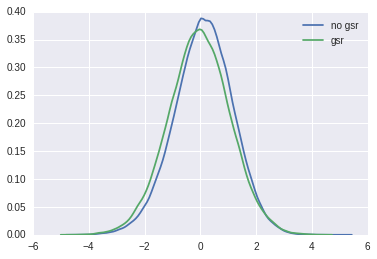

In [7]:
sns.distplot(statT.flatten(),hist=False,label='no gsr')
sns.distplot(statT_gsr.flatten(),hist=False,label="gsr")

#### T-statistics (from mixed model) measuring edgewise connectivity **_WITH GLOBAL SIGNAL REGRESSION_**

In [8]:
mncor = np.mean(connectomes,axis=2)
mncor = mncor[:,order]
mncor = mncor[order,:]

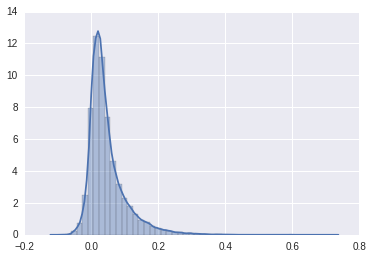

In [9]:
sns.distplot(mncor.flatten())

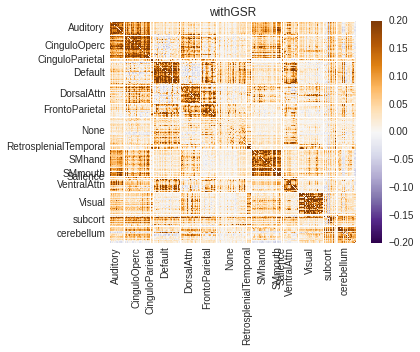

In [10]:
gordon_figure(mncor,limits=[-0.2,0.2],labelnames=labelnames,title="withGSR")

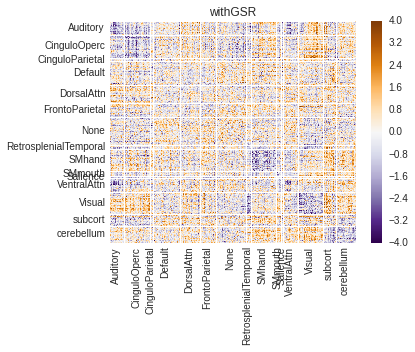

In [11]:
meancor = statT_gsr
cor_gsr = meancor[:,order]
cor_gsr = cor_gsr[order,:]

gordon_figure(cor_gsr,limits=[-4,4],labelnames=labelnames,title="withGSR")

#### T-statistics (from mixed model) measuring edgewise connectivity **_WITHOUT GLOBAL SIGNAL REGRESSION_**

In [12]:
# meancor = statT
# cor = meancor[:,order]
# cor = cor[order,:]
# gordon_figure(cor,limits=[-4,4],labelnames=labelnames,title="noGSR")

In [14]:
upid = np.triu_indices(statT.shape[0])

cor = statT[:,order]
cor = cor[order,:]
pvals = statP[upid]
hlp = np.argsort(pvals)/len(pvals)*0.05
bhpthres = np.max(pvals[pvals<hlp])
bhidx = np.where(statP<bhpthres)
bhthres = np.zeros(statP.shape)
bhthres[bhidx]=cor[bhidx]

cor_gsr = statT_gsr[:,order]
cor_gsr = cor_gsr[order,:]
pvals = statP_gsr[upid]
hlp = np.argsort(pvals)/len(pvals)*0.05
bhpthres_gsr = np.max(pvals[pvals<hlp])
bhidx = np.where(statP_gsr<bhpthres_gsr)
bhthres_gsr = np.zeros(statP.shape)
bhthres_gsr[bhidx]=cor_gsr[bhidx]

cor_gsr = statT_gsr[:,order]
cor_gsr = cor_gsr[order,:]
pvals = statP_gsr[upid]
fwethres_gsr = 0.05/len(pvals)
fweidx = np.where(statP_gsr<fwethres_gsr)
fwethres_gsr = np.zeros(statP.shape)
fwethres_gsr[fweidx]=cor_gsr[fweidx]

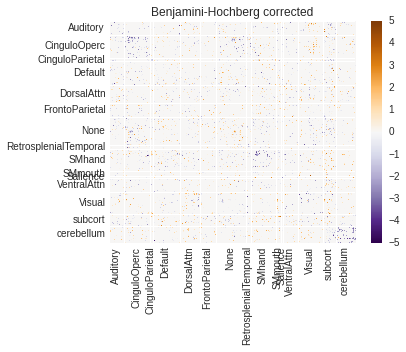

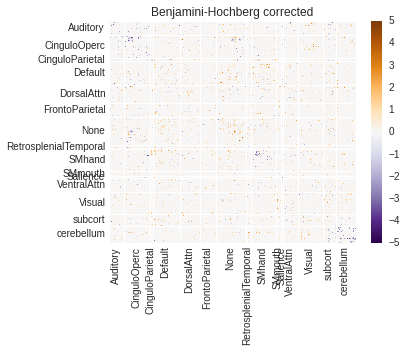

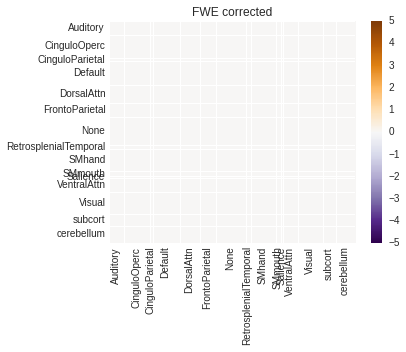

In [16]:
gordon_figure(bhthres_gsr,limits=[-5,5],labelnames=labelnames,title="Benjamini-Hochberg corrected")
gordon_figure(bhthres,limits=[-5,5],labelnames=labelnames,title="Benjamini-Hochberg corrected")
gordon_figure(fwethres_gsr,limits=[-5,5],labelnames=labelnames,title="FWE corrected")

## Networkwise

Given the pattern observable, we're testing the comparison of the average in the networks over parcels.

In [17]:
labelnames_unsorted = list(labeltable.Community)+['subcort']*20+['cerebellum']*27

In [18]:
labels = np.unique(labelnames).tolist()

avT = np.zeros([len(labels),len(labels)])
avP = np.zeros([len(labels),len(labels)])
avmat = np.zeros([len(labels),len(labels)])

for idx1,label1 in enumerate(labels):
    for idx2,label2 in enumerate(labels):
        x1 = np.where(np.array(labelnames_unsorted) == label1)[0]
        x2 = np.where(np.array(labelnames_unsorted) == label2)[0]
        subsel = connectomes[x1,:,:]
        subsel = subsel[:,x2,:]
        subsel = subsel[:,:,QAid]
        if label1==label2:
            upid = np.triu_indices(len(x1))
            av = np.mean(subsel[upid],axis=0)
        else:
            av = np.mean(subsel,axis=(0,1))
        data = pd.DataFrame({"val":av,"patient":results['patient_bin'],"subject":results['subject']})
        fit = smf.mixedlm('val ~ patient',data=data,groups=data.subject).fit()
        avT[idx1,idx2] = fit.tvalues['patient[T.True]']
        avP[idx1,idx2] = fit.pvalues['patient[T.True]']
        avmat[idx1,idx2] = np.mean(av)


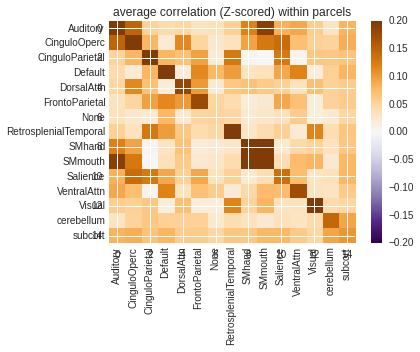

In [19]:
labels_num = np.arange(15)
#major_ticks = np.arange(15)
minor_ticks = np.arange(15)
fig = plt.figure(figsize=(6, 5), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax1 = ax.imshow(avmat,cmap = "PuOr_r",vmin=-0.2,vmax=0.2,aspect='auto',interpolation='nearest')
ax.set_title("average correlation (Z-scored) within parcels")
ax.set_xticks(minor_ticks,minor=True)
ax.set_xticklabels(labels,minor=True,rotation=90)
ax.set_yticks(minor_ticks,minor=True)
ax.set_yticklabels(labels,minor=True)
plt.colorbar(ax1)
plt.tight_layout()


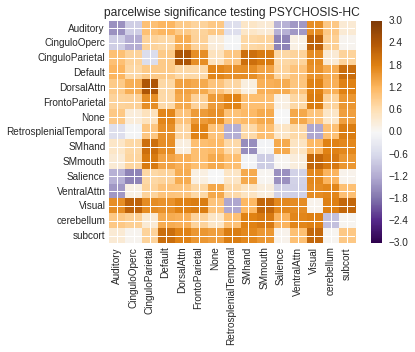

In [20]:
labels_num = np.arange(15)
major_ticks = np.arange(15)
minor_ticks = np.arange(15)
fig = plt.figure(figsize=(6, 5), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax1 = ax.imshow(avT,cmap = "PuOr_r",vmin=-3,vmax=3,aspect='auto',interpolation='nearest')
ax.set_title("parcelwise significance testing PSYCHOSIS-HC")
ax.set_xticks(major_ticks,minor=False)
ax.set_xticks(minor_ticks,minor=True)
ax.set_xticklabels(labels,minor=True,rotation=90)
ax.set_xticklabels(labels,minor=False,visible=False)
ax.set_yticks(major_ticks,minor=False)
ax.set_yticks(minor_ticks,minor=True)
ax.set_yticklabels(labels,minor=True)
ax.set_yticklabels(labels,minor=False,visible=False)
plt.colorbar(ax1)
plt.tight_layout()


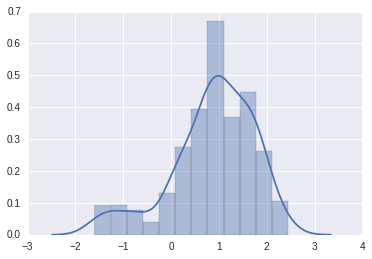

In [21]:
sns.distplot(avT.flatten())

In [22]:
upid = np.triu_indices(avP.shape[0])
pvals = avP[upid]
hlp = np.argsort(pvals)/len(pvals)*0.05
bhpthres = np.max(pvals[pvals<hlp])
bhidx = np.where(avP<bhpthres)
bhthres = np.zeros(avP.shape)
bhthres[bhidx]=avT[bhidx]
print(bhpthres)

0.0306791085822


In [23]:
#sns.distplot(bhthres.flatten())

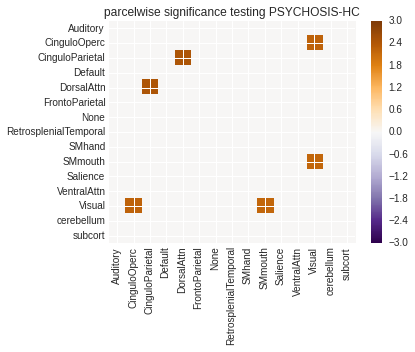

In [24]:
labels_num = np.arange(15)
major_ticks = np.arange(15)
minor_ticks = np.arange(15)
fig = plt.figure(figsize=(6, 5), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax1 = ax.imshow(bhthres,cmap = "PuOr_r",vmin=-3,vmax=3,aspect='auto',interpolation='nearest')
ax.set_title("parcelwise significance testing PSYCHOSIS-HC")
ax.set_xticks(major_ticks,minor=False)
ax.set_xticks(minor_ticks,minor=True)
ax.set_xticklabels(labels,minor=True,rotation=90)
ax.set_xticklabels(labels,minor=False,visible=False)
ax.set_yticks(major_ticks,minor=False)
ax.set_yticks(minor_ticks,minor=True)
ax.set_yticklabels(labels,minor=True)
ax.set_yticklabels(labels,minor=False,visible=False)
plt.colorbar(ax1)
plt.tight_layout()
